## References:

* Paper for Part3.: K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprint arXiv:1512.03385,2015.
* https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
* https://stackoverflow.com/questions/7691514/extracting-text-from-xml-using-python
* https://docs.python.org/2/library/xml.etree.elementtree.html
* https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
* https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial



In [ ]:
# downloading the whole dataset and unzipping it, I have used the PASCAL VOC 2012 dataset for both training and testing
! wget https://data.deepai.org/PascalVOC2012.zip
! unzip -qq "PascalVOC2012.zip"

--2020-10-03 15:03:36--  https://data.deepai.org/PascalVOC2012.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3899239928 (3.6G) [application/x-zip-compressed]
Saving to: ‘PascalVOC2012.zip’

PascalVOC2012.zip   100%[===================>]   3.63G  28.3MB/s    in 2m 13s  

2020-10-03 15:05:49 (28.0 MB/s) - ‘PascalVOC2012.zip’ saved [3899239928/3899239928]



In [ ]:
# necessary imports here
import time
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from xml.etree import cElementTree as ET
import gc
from tqdm import tqdm

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#VOC directory
voc_dir_images = "VOC2012/JPEGImages/"
voc_dir_annotations = "VOC2012/Annotations/"

In [ ]:
images = os.listdir(voc_dir_images)
annotations = os.listdir(voc_dir_annotations)

In [ ]:
# sorting images and annotations so they align
images = sorted(images)
annotations = sorted(annotations)

In [ ]:
# image0 = cv2.imread(voc_dir_images+images[0])[:,:,::-1]
# ann0 = ET.parse(voc_dir_annotations+annotations[0])
# labels[ann0.find("object/name").text]

In [ ]:
# encoding the labels
labels = {"aeroplane":0, "bicycle":1, "bird":2, "boat":3, "bottle":4,
          "bus":5, "car":6, "cat":7, "chair":8, "cow":9, "diningtable":10,
          "dog":11, "horse":12, "motorbike":13, "person":14, "pottedplant":15,
          "sheep":16, "sofa":17, "train":18, "tvmonitor":19}

In [ ]:
# reverse encoding of labels
rev_labels = {v: k for k, v in labels.items()}

In [ ]:
# defining the resize scale
resize = 32

## Defining Train set split

In [ ]:
# splitting the train and test set
len(images)   # lets keep 12000 for training and rest for testing

17125

In [ ]:
train_list = []
test_list = []
for i, item in enumerate(images):
  if i<12000:
    train_list.append(cv2.resize(cv2.imread(voc_dir_images+item)[:,:,::-1], (resize,resize)))
  else:
    test_list.append(cv2.resize(cv2.imread(voc_dir_images+item)[:,:,::-1], (resize,resize)))

In [ ]:
train_class_list = []
test_class_list = []
for i, item in enumerate(annotations):
  ann = ET.parse(voc_dir_annotations+item)
  # print(ann.find("object/name").text)
  if i<12000:
    train_class_list.append(labels[ann.find("object/name").text])
  else:
    test_class_list.append(labels[ann.find("object/name").text])

In [ ]:
# creating the train and test tensor for corresponding images and labels
train_X = torch.tensor(train_list)
train_Y = torch.tensor(train_class_list).reshape(-1,1)
test_X = torch.tensor(test_list)
test_Y = torch.tensor(test_class_list).reshape(-1,1)

In [ ]:
print(train_X.shape, train_Y.shape) # checking for the input dimensions for training set
print(test_X.shape, test_Y.shape) # checking for the input dimensions for testing set

torch.Size([12000, 32, 32, 3]) torch.Size([12000, 1])
torch.Size([5125, 32, 32, 3]) torch.Size([5125, 1])


## Visualizing some of the data

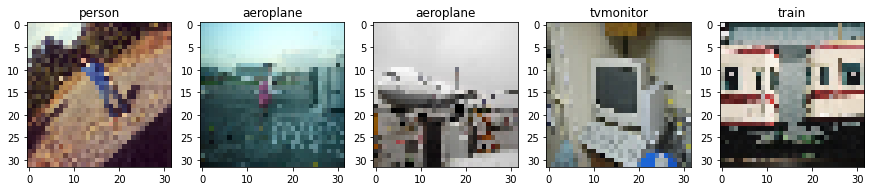

In [ ]:
# visualizing an intermediate layer output of first 8 channels
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(train_X[i])
  plt.title(rev_labels[train_Y[i].item()])
plt.show()

# PART 1. Defining the fully connected network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
class FlatNetwork(nn.Module):
    def __init__(self):
        super(FlatNetwork, self).__init__()
        self.fc1 = nn.Linear(resize * resize * 3, 1500)
        self.fc2 = nn.Linear(1500, 840)
        self.fc3 = nn.Linear(840, 300)
        self.fc4 = nn.Linear(300, 100)
        self.fc5 = nn.Linear(100, 20)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x) # not using softmax() because the loss function F.cross_entropy(), implicitly performs the softmax()
        return x

In [ ]:
FN = FlatNetwork()

In [ ]:
# definig a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(FN.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# divind into minibatches
batch_size = 128

In [ ]:
st = time.time()
for epoch in tqdm(range(6)):  # loop over the dataset multiple times

    permutation = torch.randperm(train_X.size()[0])
    running_loss = 0.0
    print()
    for i in range(0, train_X.size()[0], batch_size):
      ind = permutation[i:i+batch_size]
      batch_x = train_X[ind]
      batch_y = train_Y[ind]

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = FN(batch_x.reshape(-1,resize*resize*3).float())
      # outputs = outputs.argmax(dim=1).reshape(-1,1)
      # print(outputs.shape,batch_ y.shape)
      loss = criterion(outputs, batch_y.flatten())
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i>0 and (i // batch_size)%25 == 0:    # print after every 25th mini-batch
          print(epoch + 1, i + 1, running_loss / 25, loss.item())
          running_loss = 0.0

print('Finished Training')
et = time.time()
print("Total time taken to train Simple Neural Network: ", et-st)

  0%|          | 0/6 [00:00<?, ?it/s]


1 3201 3.419519443511963 2.8108410835266113
1 6401 2.747341289520264 2.7461929321289062
1 9601 2.746830759048462 2.637840747833252


 17%|█▋        | 1/6 [00:08<00:40,  8.13s/it]


2 3201 2.765052947998047 2.7572267055511475
2 6401 2.6541072940826416 2.749213218688965
2 9601 2.6091254806518553 2.5263123512268066


 33%|███▎      | 2/6 [00:16<00:32,  8.07s/it]


3 3201 2.6420766162872313 2.530857563018799
3 6401 2.5584423637390135 2.5459561347961426
3 9601 2.569229383468628 2.533226728439331


 50%|█████     | 3/6 [00:24<00:24,  8.04s/it]


4 3201 2.621924114227295 2.575608730316162
4 6401 2.495684223175049 2.433056116104126
4 9601 2.4998268413543703 2.3158063888549805


 67%|██████▋   | 4/6 [00:32<00:16,  8.05s/it]


5 3201 2.5374070835113525 2.3925211429595947
5 6401 2.4811302280426024 2.732858180999756
5 9601 2.4897368240356443 2.5244858264923096


 83%|████████▎ | 5/6 [00:40<00:08,  8.01s/it]


6 3201 2.54065336227417 2.5538501739501953
6 6401 2.432992210388184 2.5280511379241943
6 9601 2.424834690093994 2.4537506103515625


100%|██████████| 6/6 [00:48<00:00,  8.01s/it]

Finished Training
Total time taken to train Simple Neural Network:  48.055033922195435


In [ ]:
# saving the trained model
torch.save(FN.state_dict(), "FlatNet_model")

### Prediction on Test set, using the Flat network

In [ ]:
# comment this cell block if training from scratch again
# also, to run this cell first drop all the trained model present in the shared drive folder Q1_models
FN = FlatNetwork()
FN.load_state_dict(torch.load("FlatNet_model"))

<All keys matched successfully>

In [ ]:
print(FN)   # checking the flat network summary

FlatNetwork(
  (fc1): Linear(in_features=3072, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=840, bias=True)
  (fc3): Linear(in_features=840, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=20, bias=True)
)


In [ ]:
# https://deeplizard.com/learn/video/6vweQjouLEE
FN_preds = FN(test_X.reshape(-1,resize*resize*3).float())

In [ ]:
# calculating the accuracy on the test set
# for different runs of the model, getting accuracy between 59% to 85%
print("Flat NN model accuracy on test: ", (FN_preds.argmax(dim=1).reshape(-1,1) == test_Y).sum().item() / test_Y.shape[0] *100)

Flat NN model accuracy on test:  61.44390243902439




---



---



# Part 2. Designing a simple CNN

In [ ]:
class SCNN(nn.Module):
    def __init__(self):
        super(SCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.fc1 = nn.Linear(15*15* 8, 1200)  # 15 is the mutated image dimension
        self.fc2 = nn.Linear(1200, 860)
        self.fc3 = nn.Linear(860, 300)
        self.fc4 = nn.Linear(300, 100)
        self.fc5 = nn.Linear(100, 20)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x) # not using softmax() because the loss function F.cross_entropy(), implicitly performs the softmax()
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_feats = 1
        for sz in size:
            num_feats *= sz
        return num_feats
      
    def intermediary_layer_visualization(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        return x

In [ ]:
SimpleCNN = SCNN()

In [ ]:
# definig a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SimpleCNN.parameters(), lr=0.001, momentum=0.9)
batch_size = 128

In [ ]:
# using the same training regime as FlatNetwork
st = time.time()
for epoch in tqdm(range(6)):  # loop over the dataset multiple times

    permutation = torch.randperm(train_X.size()[0])
    running_loss = 0.0
    print()
    for i in range(0, train_X.size()[0], batch_size):
      ind = permutation[i:i+batch_size]
      batch_x = train_X[ind]
      batch_y = train_Y[ind]

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = SimpleCNN(batch_x.permute(0,3,1,2).float())
      # outputs = outputs.argmax(dim=1).reshape(-1,1)
      # print(outputs.shape,batch_ y.shape)
      loss = criterion(outputs, batch_y.flatten())
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i>0 and (i // batch_size)%25 == 0:    # print after every 25th mini-batch
          print(epoch + 1, i + 1, running_loss / 25, loss.item())
          running_loss = 0.0

print('Finished Training')
et = time.time()
print("Total time taken to train Simple CNN: ", et-st)

  0%|          | 0/6 [00:00<?, ?it/s]


1 3201 2.997080535888672 2.7245702743530273
1 6401 2.7007402324676515 2.8900341987609863
1 9601 2.634915428161621 2.7631592750549316


 17%|█▋        | 1/6 [00:07<00:37,  7.53s/it]


2 3201 2.659238634109497 2.592139959335327
2 6401 2.5404051780700683 2.5830066204071045
2 9601 2.523459625244141 2.575188159942627


 33%|███▎      | 2/6 [00:14<00:30,  7.51s/it]


3 3201 2.5088697814941407 2.600996494293213
3 6401 2.437874536514282 2.362739086151123
3 9601 2.402951326370239 2.272261142730713


 50%|█████     | 3/6 [00:22<00:22,  7.48s/it]


4 3201 2.408182353973389 2.4140844345092773
4 6401 2.403565034866333 2.439199447631836
4 9601 2.2849067497253417 2.391003131866455


 67%|██████▋   | 4/6 [00:29<00:14,  7.46s/it]


5 3201 2.365308151245117 2.33830189704895
5 6401 2.2814448165893553 2.310196876525879
5 9601 2.2428333282470705 2.094031810760498


 83%|████████▎ | 5/6 [00:37<00:07,  7.46s/it]


6 3201 2.285907688140869 2.2240865230560303
6 6401 2.1793129730224607 2.2320291996002197
6 9601 2.1223611974716188 1.9170379638671875


100%|██████████| 6/6 [00:44<00:00,  7.45s/it]

Finished Training
Total time taken to train Simple CNN:  44.73390197753906


In [ ]:
# saving the trained model
torch.save(SimpleCNN.state_dict(), "SimpleCNN_model")

### Prediction on Test set, using the Flat network

In [ ]:
# comment this cell block if training from scratch again
# also, to run this cell first drop all the trained model present in the shared drive folder Q1_models
SimpleCNN = SCNN()
SimpleCNN.load_state_dict(torch.load("SimpleCNN_model"))

<All keys matched successfully>

In [ ]:
print(SimpleCNN)

SCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1800, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=860, bias=True)
  (fc3): Linear(in_features=860, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=20, bias=True)
)


In [ ]:
SCNN_preds = SimpleCNN(test_X.permute(0,3,1,2).float())
print("Simple CNN model accuracy on test: ", (SCNN_preds.argmax(dim=1).reshape(-1,1) == test_Y).sum().item() / test_Y.shape[0] *100)

Simple CNN model accuracy on test:  65.60000000000001


### Visualization

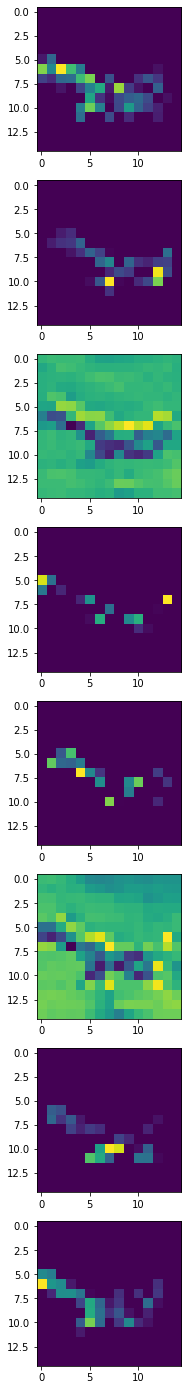

Label:  aeroplane


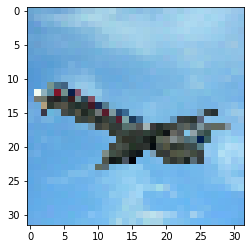

In [ ]:
# visualizing an intermediate layer output
plt.figure(figsize=(8,25))
for i in range(8):
  plt.subplot(8,1,i+1)
  plt.imshow((SimpleCNN.intermediary_layer_visualization(test_X[0].permute(2,0,1).float().reshape(1,3,32,32)))[0][i].detach().numpy())
plt.show()
plt.imshow(test_X[0])
print("Label: ", rev_labels[test_Y[0].item()])
plt.show()



---



---



# Part 3. Designing a Deep CNN

In [ ]:
# https://missinglink.ai/guides/pytorch/pytorch-resnet-building-training-scaling-residual-networks-pytorch/

In [ ]:
# first creating a basic block module
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_c, out_c, stride=1):
      super(BasicBlock, self).__init__()
      self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(out_c)
      self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(out_c)

      self.skip = nn.Sequential()
      if stride != 1 or in_c != self.expansion*out_c:
          self.skip = nn.Sequential(nn.Conv2d(in_c, self.expansion*out_c, kernel_size=1, stride=stride, bias=False),
                                    nn.BatchNorm2d(self.expansion*out_c))
    
    def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.skip(x)
      out = F.relu(out)
      return out

In [ ]:
# the resnet module
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=20):
      super(ResNet, self).__init__()
      self.in_c = 64
      self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(64)
      self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
      self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
      self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
      self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
      self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, out_c, num_blocks, stride):
      strides = [stride] + [1]*(num_blocks-1)
      layers = []
      for stride in strides:
          layers.append(block(self.in_c, out_c, stride))
          self.in_c = out_c * block.expansion
      return nn.Sequential(*layers)

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = F.avg_pool2d(out, 4)
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out

  def intermediary_layer_visualization(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      return out

In [ ]:
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# definig a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
batch_size = 128

In [ ]:
# using the same training regime as FlatNetwork
st = time.time()
for epoch in tqdm(range(1)):  # loop over the dataset multiple times
    permutation = torch.randperm(train_X.size()[0])
    running_loss = 0.0
    for i in range(0, train_X.size()[0], batch_size):
      ind = permutation[i:i+batch_size]
      batch_x = train_X[ind]
      batch_y = train_Y[ind]

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = resnet18(batch_x.permute(0,3,1,2).float())
      # outputs = outputs.argmax(dim=1).reshape(-1,1)
      # print(outputs.shape,batch_ y.shape)
      loss = criterion(outputs, batch_y.flatten())
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i>0 and (i // batch_size)%2 == 0:    # print after every 3rd mini-batch
          print(epoch + 1, i + 1, running_loss / 25, loss.item())
          running_loss = 0.0

print('Finished Training')
et = time.time()
print("Total time taken to train Resnet34: ", et-st)

  0%|          | 0/1 [00:00<?, ?it/s]

1 257 0.37158143043518066 3.083411455154419
1 513 0.24306005477905274 2.9742817878723145
1 769 0.23510108947753905 2.953247547149658
1 1025 0.22517794609069824 2.819289445877075
1 1281 0.2165866184234619 2.6517999172210693
1 1537 0.2200999927520752 2.8003058433532715
1 1793 0.23582119941711427 2.9000699520111084
1 2049 0.21579333305358886 2.6764936447143555
1 2305 0.21982352256774904 2.6978464126586914
1 2561 0.21846712112426758 2.6119775772094727
1 2817 0.22317808151245117 2.786220073699951
1 3073 0.2149420738220215 2.698617458343506
1 3329 0.21824949264526367 2.69535231590271
1 3585 0.21822592735290527 2.728020429611206
1 3841 0.21941370010375977 2.7664732933044434
1 4097 0.20849353790283204 2.5747320652008057
1 4353 0.2071600914001465 2.5872650146484375
1 4609 0.2055959129333496 2.535020351409912
1 4865 0.20579618453979492 2.623884677886963
1 5121 0.21231640815734865 2.70529842376709
1 5377 0.21206350326538087 2.7108640670776367
1 5633 0.21028130531311034 2.691389322280884
1 5889 0.

100%|██████████| 1/1 [15:17<00:00, 917.18s/it]

Finished Training
Total time taken to train Resnet34:  917.1806728839874


In [ ]:
# saving the trained model
torch.save(resnet18.state_dict(), "resnet18_model")

### Prediction on Test set, using the resnet18 network

In [ ]:
# comment this cell block if training from scratch again
# also, to run this cell first drop all the trained model present in the shared drive folder Q1_models
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2])
resnet18.load_state_dict(torch.load("resnet18_model"))

<All keys matched successfully>

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
# Since the architechture is deeper, we want to test predictions in batches
test_batch_size = 125
acc_sum = 0
for bat,i in enumerate(range(0, test_X.size()[0], test_batch_size)):
      #ind = [i:i+test_batch_size]
      batch_x = test_X[i:i+test_batch_size]
      batch_y = test_Y[i:i+test_batch_size]
      res_preds = resnet18(batch_x.permute(0,3,1,2).float())
      acc_sum += (res_preds.argmax(dim=1).reshape(-1,1) == batch_y).sum().item() / batch_y.shape[0] *100
      print("RESNET CNN model accuracy on test batch", bat+1,": ", (res_preds.argmax(dim=1).reshape(-1,1) == batch_y).sum().item() / batch_y.shape[0] *100)
print("RESNET CNN model overall accuracy on test set is: ", acc_sum/(test_Y.shape[0]/test_batch_size))

RESNET CNN model accuracy on test batch 1 :  25.6
RESNET CNN model accuracy on test batch 2 :  16.8
RESNET CNN model accuracy on test batch 3 :  18.4
RESNET CNN model accuracy on test batch 4 :  24.0
RESNET CNN model accuracy on test batch 5 :  26.400000000000002
RESNET CNN model accuracy on test batch 6 :  28.000000000000004
RESNET CNN model accuracy on test batch 7 :  17.599999999999998
RESNET CNN model accuracy on test batch 8 :  22.400000000000002
RESNET CNN model accuracy on test batch 9 :  88.0
RESNET CNN model accuracy on test batch 10 :  81.6
RESNET CNN model accuracy on test batch 11 :  82.39999999999999
RESNET CNN model accuracy on test batch 12 :  86.4
RESNET CNN model accuracy on test batch 13 :  80.0
RESNET CNN model accuracy on test batch 14 :  83.2
RESNET CNN model accuracy on test batch 15 :  82.39999999999999
RESNET CNN model accuracy on test batch 16 :  84.0
RESNET CNN model accuracy on test batch 17 :  87.2
RESNET CNN model accuracy on test batch 18 :  84.0
RESNET CN

### Visulization

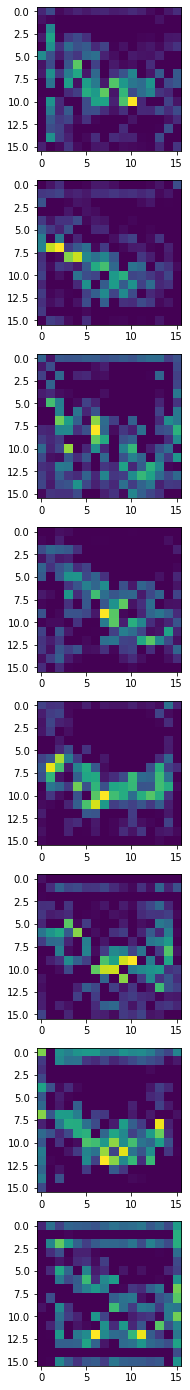

Label:  aeroplane


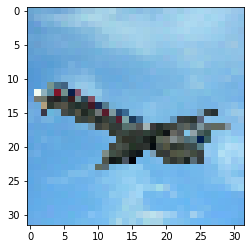

In [ ]:
# visualizing an intermediate layer output of first 8 channels
plt.figure(figsize=(8,25))
for i in range(8):
  plt.subplot(8,1,i+1)
  plt.imshow((resnet18.intermediary_layer_visualization(test_X[0].permute(2,0,1).float().reshape(1,3,32,32)))[0][i].detach().numpy())
plt.show()
plt.imshow(test_X[0])
print("Label: ", rev_labels[test_Y[0].item()])
plt.show()

# Analysis and comparision

**Time Comparision**
* The Flat Neural Network took **48.05s** to complete training for 6 epochs on 12000 images of size 32x32x3 (i.e. 3 channels RGB)
* The Simple CNN with single convolution and pooling layer took **44.73s** to complete the training procedure for 6 epochs
* The Deep CNN i.e. Resnet18 architecture took **917.18s** to complete the training process for a single epoch. 

**Accuracy on test set**
* Flat NN model accuracy on test:  **61.44390243902439 %**
* Simple CNN model accuracy on test:  **65.60000000000001 %**
* RESNET CNN model overall accuracy on test set is:  **71.2 %**

**Final Thoughts**
* Since the overall dataset size is roughly 17000, deep networks like resnet gives average performance as this network has a huge hunger for data, which the current dataset does'nt provide much.